elapsed time: 347.59011500002816


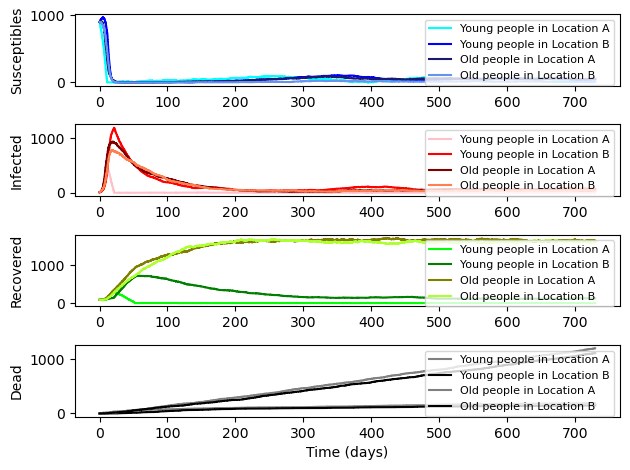

<Figure size 2560x2560 with 0 Axes>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from numba import jit
from matplotlib.pyplot import figure

Number_Age_Classes = 2
Number_Locations = 2

#alpha is the rate at which members of our population age up from young to old
alpha = 0.01
#beta is the infection rate. First input is for the young, second for the old
beta = np.array([1, 1])
#sigma_i,j is how infectious people from location i are on people from location j
sigma = np.array([[1,1],[1,1]])
#gamma is the recovery rate - Rows represent age and columns location
gamma = np.array([[1/50, 1/50],[1/50,1/50]])
#mu is the death rate. Rows represent each infection state, while columns represent age, each subcolumn represents location
mu = 1e-3 * np.array([[[1,1], [1,1]], [[1,1], [1,1]], [[1,1], [1,1]]])
#nu is the amount at which the disease tends to spread from locations a and b respectively. Rows represent the location infection is from and columns the location it's spreading to
nu = np.array([[1, 0],[0, 1]])
#migration rate, rows represent age, while columns suggest location the migration is from - if we had more than 2 locations we'd have to rethink this
migration_rate = 1e-2 * np.array([[1,1],[1,1]])
birth_rate = 0.001
N0 = np.array([4000])
ND = MaxTime = 2 * 365
I0 = (10 * np.array([[1,1],[1,1]])).tolist()
S0 = (900 * np.array([[1,1],[1,1]])).tolist()
R0 = (90 * np.array([[1,1],[1,1]])).tolist()
D0 = [[0,0],[0,0]]

INPUT = [S0,I0,R0,D0]
timestep=0.0

@jit(nopython=True)
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

def Stochastic_equations(INP,ts): 
    Number_of_Rules = 12
    Number_of_SubRules = 4
    Number_of_SubSubRules = 4
    Rate = np.zeros((Number_of_Rules))
    SubRate = np.zeros((Number_of_Rules, Number_of_SubRules))
    SubSubRate = np.zeros((Number_of_Rules, Number_of_SubRules, Number_of_SubSubRules))
    Pop_Change = np.zeros((Number_of_Rules, Number_of_SubRules, Number_of_SubSubRules, 4, Number_Age_Classes, Number_Locations))
    N = np.sum(INP[0]+INP[1]+INP[2])
    #rule 1: S to S (susceptible ageing)
    #subrule 1: Y to O
    #subsubrule 1: Location A
    SubSubRate[0, 0, 0] = alpha * INP[0][0][0]
    Pop_Change[0, 0, 0,:] = np.array([[[-1,0],[+1,0]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B
    SubSubRate[0, 0, 1] = alpha * INP[0][0][1]
    Pop_Change[0, 0, 1,:] = np.array([[[0,-1],[0,+1]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #rule 2: I+S to I+I (infection)
    #subrule 1: Y+Y (young infected by young)
    #subsubrule 1: Location A to Location A ***
    SubSubRate[1, 0, 0] = nu[0][0] * (beta[0]**2) * INP[0][0][0] * INP[1][0][0] / N
    Pop_Change[1, 0, 0,:] = np.array([[[-1,0],[0,0]], [[+1,0],[0, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B to Location A ***
    SubSubRate[1, 0, 1] = nu[1][0] * (beta[0]**2) * INP[0][0][1] * INP[1][0][0] / N
    Pop_Change[1, 0, 1,:] = np.array([[[-1,0],[0,0]], [[+1,0],[0, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])   
    #subsubrule 3: Location A to Location B ***
    SubSubRate[1, 0, 2] = nu[0][1] * (beta[0]**2) * INP[0][0][0] * INP[1][0][1] / N
    Pop_Change[1, 0, 2,:] = np.array([[[0,-1],[0,0]], [[0,+1],[0, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 4: Location B to Location B ***
    SubSubRate[1, 0, 3] = nu[1][1] * (beta[0]**2) * INP[0][0][1] * INP[1][0][1] / N
    Pop_Change[1, 0, 3,:] = np.array([[[0,-1],[0,0]], [[0,+1],[0, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subrule 2: O+Y (young infected by old)
    #subsubrule 1: Location A to Location A ***
    SubSubRate[1, 1, 0] = nu[0][0] * (beta[0]*beta[1]) * INP[0][0][0] * INP[1][1][0] / N
    Pop_Change[1, 1, 0,:] = np.array([[[-1,0],[0,0]], [[+1,0],[0, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B to Location A ***
    SubSubRate[1, 1, 1] = nu[1][0] * (beta[0]*beta[1]) * INP[0][0][1] * INP[1][1][0] / N
    Pop_Change[1, 1, 1,:] = np.array([[[-1,0],[0,0]], [[+1,0],[0, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])   
    #subsubrule 3: Location A to Location B ***
    SubSubRate[1, 1, 2] = nu[0][1] * (beta[0]*beta[1]) * INP[0][0][0] * INP[1][1][1] / N
    Pop_Change[1, 1, 2,:] = np.array([[[0,-1],[0,0]], [[0,+1],[0, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 4: Location B to Location B ***
    SubSubRate[1, 1, 3] = nu[1][1] * (beta[0]*beta[1]) * INP[0][0][1] * INP[1][1][1] / N
    Pop_Change[1, 1, 3,:] = np.array([[[0,-1],[0,0]], [[0,+1],[0, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subrule 3: Y+O (old infected by young)
    #subsubrule 1: Location A to Location A ***
    SubSubRate[1, 2, 0] = nu[0][0] * (beta[0]*beta[1]) * INP[0][1][0] * INP[1][0][0] / N
    Pop_Change[1, 2, 0,:] = np.array([[[0,0],[-1,0]], [[0,0],[+1, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B to Location A ***
    SubSubRate[1, 2, 1] = nu[1][0] * (beta[0]*beta[1]) * INP[0][1][1] * INP[1][0][0] / N
    Pop_Change[1, 2, 1,:] = np.array([[[0,0],[-1,0]], [[0,0],[+1, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])   
    #subsubrule 3: Location A to Location B ***
    SubSubRate[1, 2, 2] = nu[0][1] * (beta[0]*beta[1]) * INP[0][1][0] * INP[1][0][1] / N
    Pop_Change[1, 2, 2,:] = np.array([[[0,0],[0,-1]], [[0,0],[0, +1]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 4: Location B to Location B ***
    SubSubRate[1, 2, 3] = nu[1][1] * (beta[0]*beta[1]) * INP[0][1][1] * INP[1][0][1] / N
    Pop_Change[1, 2, 3,:] = np.array([[[0,0],[0,-1]], [[0,0],[0, +1]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subrule 4: O+O (old infected by old)
    #subsubrule 1: Location A to Location A ***
    SubSubRate[1, 3, 0] = nu[0][0] * (beta[0]*beta[1]) * INP[0][1][0] * INP[1][1][0] / N
    Pop_Change[1, 3, 0,:] = np.array([[[0,0],[-1,0]], [[0,0],[+1, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B to Location A ***
    SubSubRate[1, 3, 1] = nu[1][0] * (beta[0]*beta[1]) * INP[0][1][1] * INP[1][1][0] / N
    Pop_Change[1, 3, 1,:] = np.array([[[0,0],[-1,0]], [[0,0],[+1, 0]], [[0,0],[0,0]], [[0,0],[0,0]]])   
    #subsubrule 3: Location A to Location B ***
    SubSubRate[1, 3, 2] = nu[0][1] * (beta[0]*beta[1]) * INP[0][1][0] * INP[1][1][1] / N
    Pop_Change[1, 3, 2,:] = np.array([[[0,0],[0,-1]], [[0,0],[0, +1]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 4: Location B to Location B ***
    SubSubRate[1, 3, 3] = nu[1][1] * (beta[0]*beta[1]) * INP[0][1][1] * INP[1][1][1] / N
    Pop_Change[1, 3, 3,:] = np.array([[[0,0],[0,-1]], [[0,0],[0, +1]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #rule 3: S to D (susceptible death)
    #subrule 1: Y
    #subsubrule: Location A:
    SubSubRate[2, 0, 0] = mu[0][0][0] * INP[0][0][0]
    Pop_Change[2, 0, 0,:] = np.array([[[-1,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]], [[+1,0],[0,0]]])
    #subsubrule: Location B:
    SubSubRate[2, 0, 1] = mu[0][0][1] * INP[0][0][1]
    Pop_Change[2, 0, 1,:] = np.array([[[0,-1],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,+1],[0,0]]])   
    #subrule 2: O
    #subsubrule: Location A:
    SubSubRate[2, 1, 0] = mu[0][1][0] * INP[0][1][0]
    Pop_Change[2, 1, 0,:] = np.array([[[0,0],[-1,0]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[+1,0]]])
    #subsubrule: Location B:
    SubSubRate[2, 0, 1] = mu[0][1][1] * INP[0][1][1]
    Pop_Change[2, 0, 1,:] = np.array([[[0,0],[0,-1]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,+1]]])
    #rule 4: I to I (infected ageing)
    #subrule 1: Y to O
    #subsubrule 1: Location A
    SubSubRate[3, 0, 0] = alpha * INP[1][0][0]
    Pop_Change[3, 0, 0,:] = np.array([[[0,0],[0,0]], [[-1,0],[+1,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B
    SubSubRate[3, 0, 1] = alpha * INP[1][0][1]
    Pop_Change[3, 0, 1,:] = np.array([[[0,0],[0,0]], [[0,-1],[0,+1]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #rule 5: I to R (infected recovery)
    #subrule 1: Y
    #subsubrule 1: Location A
    SubSubRate[4, 0, 0] = gamma[0][0] * INP[1][0][0]
    Pop_Change[4, 0, 0,:] = np.array([[[0,0],[0,0]], [[-1,0],[0,0]], [[+1,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B
    SubSubRate[4, 0, 1] = gamma[0][1] * INP[1][0][1]
    Pop_Change[4, 0, 1,:] = np.array([[[0,0],[0,0]], [[0,-1],[0,0]], [[0,+1],[0,0]], [[0,0],[0,0]]])
    #subrule 2: O
    #subsubrule 1: Location A
    SubSubRate[4, 1, 0] = gamma[1][0] * INP[1][1][0]
    Pop_Change[4, 1, 0,:] = np.array([[[0,0],[0,0]], [[0,0],[-1,0]], [[0,0],[+1,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B
    SubSubRate[4, 1, 1] = gamma[1][1] * INP[1][1][1]
    Pop_Change[4, 1, 1,:] = np.array([[[0,0],[0,0]], [[0,0],[0,-1]], [[0,0],[0,+1]], [[0,0],[0,0]]])
    #rule 6: I to D (infected death)
    #subrule 1: Y
    #subsubrule: Location A:
    SubSubRate[5, 0, 0] = mu[1][0][0] * INP[1][0][0]
    Pop_Change[5, 0, 0,:] = np.array([[[0,0],[0,0]], [[-1,0],[0,0]], [[0,0],[0,0]], [[+1,0],[0,0]]])
    #subsubrule: Location B:
    SubSubRate[5, 0, 1] = mu[1][0][1] * INP[1][0][1]
    Pop_Change[5, 0, 1,:] = np.array([[[0,0],[0,0]], [[0,-1],[0,0]], [[0,0],[0,0]], [[0,+1],[0,0]]])   
    #subrule 2: O
    #subsubrule: Location A:
    SubSubRate[5, 1, 0] = mu[1][1][0] * INP[1][1][0]
    Pop_Change[5, 1, 0,:] = np.array([[[0,0],[0,0]], [[0,0],[-1,0]], [[0,0],[0,0]], [[0,0],[+1,0]]])
    #subsubrule: Location B:
    SubSubRate[5, 1, 1] = mu[1][1][1] * INP[1][1][1]
    Pop_Change[5, 1, 1,:] = np.array([[[0,0],[0,0]], [[0,0],[0,-1]], [[0,0],[0,0]], [[0,0],[0,+1]]])
    #rule 7: R to R (recovered ageing)
    #subrule 1; Y to O
    #subsubrule 1: Location A
    SubSubRate[6, 0, 0] = alpha * INP[2][0][0]
    Pop_Change[6, 0, 0,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[-1,0],[+1,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B
    SubSubRate[6, 0, 1] = alpha * INP[2][0][1]
    Pop_Change[6, 0, 1,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[0,-1],[0,+1]], [[0,0],[0,0]]])
    #rule 8: R to D (recovered death)
    #subrule 1: Y
    #subsubrule: Location A:
    SubSubRate[7, 0, 0] = mu[2][0][0] * INP[2][0][0]
    Pop_Change[7, 0, 0,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[-1,0],[0,0]], [[+1,0],[0,0]]])
    #subsubrule: Location B:
    SubSubRate[7, 0, 1] = mu[2][0][1] * INP[2][0][1]
    Pop_Change[7, 0, 1,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[0,-1],[0,0]], [[0,+1],[0,0]]])   
    #subrule 2: O
    #subsubrule: Location A:
    SubSubRate[7, 1, 0] = mu[2][1][0] * INP[2][1][0]
    Pop_Change[7, 1, 0,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[-1,0]], [[0,0],[+1,0]]])
    #subsubrule: Location B:
    SubSubRate[7, 1, 1] = mu[2][1][1] * INP[2][1][1]
    Pop_Change[7, 1, 1,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,-1]], [[0,0],[0,+1]]])
    #rule 9: Birth: 
    #subrule 1:
    #subsubrule 1: Location A:
    SubSubRate[8, 0,0] = birth_rate * (INP[0]+INP[1]+INP[2])[1][0]
    Pop_Change[8, 0, 0,:] = np.array([[[+1,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 2: Location B:
    SubSubRate[8, 0, 1] = birth_rate * (INP[0]+INP[1]+INP[2])[1][1]
    Pop_Change[8, 0, 1,:] = np.array([[[0,+1],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #rule 10: Susceptible Migration:
    #subrule 1: Y
    #subsubrule 1: Location A to Location B:
    SubSubRate[9, 0, 0] = migration_rate[0][0] * INP[0][0][0]
    Pop_Change[9, 0, 0,:] = np.array([[[-1,+1],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 1: Location B to Location A:
    SubSubRate[9, 0, 1] = migration_rate[0][1] * INP[0][0][1]
    Pop_Change[9, 0, 1,:] = np.array([[[+1,-1],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subrule 2: O
    #subsubrule 1: Location A to Location B:
    SubSubRate[9, 1, 0] = migration_rate[1][0] * INP[0][1][0]
    Pop_Change[9, 1, 0,:] = np.array([[[0,0],[-1,+1]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 1: Location B to Location A:
    SubSubRate[9, 1, 1] = migration_rate[1][1] * INP[0][1][1]
    Pop_Change[9, 1, 1,:] = np.array([[[0,0],[+1,-1]], [[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #rule 11: Infected Migration:
    #subrule 1: Y
    #subsubrule 1: Location A to Location B:
    SubSubRate[10, 0, 0] = migration_rate[0][0] * INP[1][0][0]
    Pop_Change[10, 0, 0,:] = np.array([[[0,0],[0,0]], [[-1,+1],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 1: Location B to Location A:
    SubSubRate[10, 0, 1] = migration_rate[0][1] * INP[1][0][1]
    Pop_Change[10, 0, 1,:] = np.array([[[0,0],[0,0]], [[+1,-1],[0,0]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subrule 2: O
    #subsubrule 1: Location A to Location B:
    SubSubRate[10, 1, 0] = migration_rate[1][0] * INP[1][1][0]
    Pop_Change[10, 1, 0,:] = np.array([[[0,0],[0,0]], [[0,0],[-1,+1]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #subsubrule 1: Location B to Location A:
    SubSubRate[10, 1, 1] = migration_rate[1][1] * INP[1][1][1]
    Pop_Change[10, 1, 1,:] = np.array([[[0,0],[0,0]], [[0,0],[+1,-1]], [[0,0],[0,0]], [[0,0],[0,0]]])
    #rule 12: Recovered Migration:
    #subrule 1: Y
    #subsubrule 1: Location A to Location B:
    SubSubRate[11, 0, 0] = migration_rate[0][0] * INP[2][0][0]
    Pop_Change[11, 0, 0,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[-1,+1],[0,0]], [[0,0],[0,0]]])
    #subsubrule 1: Location B to Location A:
    SubSubRate[11, 0, 1] = migration_rate[0][1] * INP[2][0][1]
    Pop_Change[11, 0, 1,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[+1,-1],[0,0]], [[0,0],[0,0]]])
    #subrule 2: O
    #subsubrule 1: Location A to Location B:
    SubSubRate[11, 1, 0] = migration_rate[1][0] * INP[2][1][0]
    Pop_Change[11, 1, 0,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[-1,+1]], [[0,0],[0,0]]])
    #subsubrule 1: Location B to Location A:
    SubSubRate[11, 1, 1] = migration_rate[1][1] * INP[2][1][1]
    Pop_Change[11, 1, 1,:] = np.array([[[0,0],[0,0]], [[0,0],[0,0]], [[0,0],[+1,-1]], [[0,0],[0,0]]])
    for i in range(len(Rate)):
        for j in range(np.ma.size(SubSubRate[i], 0)):
            SubRate[i][j] = np.sum(SubSubRate[i][j])
    for i in range(len(Rate)):
        Rate[i] = np.sum(SubRate[i])
    r1 = np.random.rand() 
    r2 = np.random.rand()
    ts = -np.log(r1) / (np.sum(Rate));
    #decides what equation to use
    m1 = min(find(np.cumsum(Rate) >= np.sum(Rate) * r2));
    if Rate[m1] == 0:
        for i in range(Number_of_Rules):
            if Rate[m1] == 0:
                m1 +=1
    r2 = r2 - (np.cumsum(Rate)[m1-1]/np.sum(Rate))
    m2 = min(find(np.cumsum(SubRate[m1]) >= np.sum(Rate) * r2));
    if SubRate[m1][m2] == 0:
        for i in range(Number_of_SubRules):
            if SubRate[m1][m2] == 0:
                m2 +=1
    r2 = r2 - (np.cumsum(SubRate[m1])[m2-1]/np.sum(Rate))
    m3 = min(find(np.cumsum(SubSubRate[m1][m2]) >=np.sum(Rate) * r2))
    if SubSubRate[m1][m2][m3] == 0:
        for i in range(Number_of_SubSubRules):
            if SubSubRate[m1][m2][m3] == 0:
                m3 +=1
    INP += Pop_Change[m1, m2, m3, :]
    return [INP,ts]

def Stochastic_iteration(INPUT):
    counter = 0
    ts = 0
    T = np.array([0])
    S = np.array([[[0,0],[0,0]]])
    I = np.array([[[0,0],[0,0]]])
    R = np.array([[[0,0],[0,0]]])
    D = np.array([[[0,0],[0,0]]])
    while T[counter] < ND:
        counter+=1
        T = np.concatenate((T, np.array([T[counter-1]+ts])))
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1]])))
        R = np.concatenate((R, np.array([INPUT[2]])))
        D = np.concatenate((D, np.array([INPUT[3]])))
        [INPUT,ts] = Stochastic_equations(INPUT,ts)
        counter+=1
        T = np.concatenate((T, np.array([T[counter-1]])))
        S = np.squeeze(S)
        I = np.squeeze(I)
        R = np.squeeze(R)
        D = np.squeeze(D)
        #note that squuezing requires a surprising amount of computational power. Were this method to be tested we'd have to remove this
        #however I could not get the method to work without including this
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1]])))
        R = np.concatenate((R, np.array([INPUT[2]])))
        D = np.concatenate((D, np.array([INPUT[3]])))
    return [T,S,I,R,D]

start = timer()
[T,S,I,R,D]=Stochastic_iteration(INPUT)
end = timer()

print(f'elapsed time: {end - start}')


tT=np.array(T)[1:,]
tS=np.array(S)[1:,]
tI=np.array(I)[1:,]
tR=np.array(R)[1:,]
tD=np.array(D)[1:,]

plt.subplot(4, 1, 1)
plt.plot(tT, tS[:,0, 0],'cyan', label = 'Young people in Location A')
plt.plot(tT, tS[:,0, 1],'blue', label = 'Young people in Location B')
plt.plot(tT, tS[:,1, 0],'midnightblue', label = 'Old people in Location A')
plt.plot(tT, tS[:,1, 1],'cornflowerblue', label = 'Old people in Location B')
plt.legend(loc ="upper right", fontsize="8")
plt.ylabel ('Susceptibles')
plt.subplot(4, 1, 2)
plt.plot(tT, tI[:,0, 0], 'pink', label = 'Young people in Location A')
plt.plot(tT, tI[:,0, 1], 'red', label = 'Young people in Location B')
plt.plot(tT, tI[:,1, 0], 'maroon', label = 'Old people in Location A')
plt.plot(tT, tI[:,1, 1], 'coral', label = 'Old people in Location B')
plt.legend(loc ="upper right", fontsize="8")
plt.ylabel ('Infected')
plt.subplot(4, 1, 3)
plt.plot(tT, tR[:,0, 0], 'lime', label = 'Young people in Location A')
plt.plot(tT, tR[:,0, 1], 'green', label = 'Young people in Location B')
plt.plot(tT, tR[:,1, 0], 'olive', label = 'Old people in Location A')
plt.plot(tT, tR[:,1, 1], 'greenyellow', label = 'Old people in Location B')
plt.legend(loc ="upper right", fontsize="8")
plt.ylabel ('Recovered')
plt.subplot(4, 1, 4)
plt.plot(tT, tD[:,0, 0], 'grey', label = 'Young people in Location A')
plt.plot(tT, tD[:,0, 1], 'black', label = 'Young people in Location B')
plt.plot(tT, tD[:,1, 0], 'grey', label = 'Old people in Location A')
plt.plot(tT, tD[:,1, 1], 'black', label = 'Old people in Location B')
plt.legend(loc ="upper right", fontsize="8")
plt.ylabel ('Dead')
plt.xlabel ('Time (days)')
plt.tight_layout()
plt.savefig('Plots for Deep HKO algorithm')
figure(figsize=(16, 16), dpi=160)
plt.show()

Above you can see the plots and code for the Deep HKO method I have outlined in the PDF. Note this isn't a very well optimised method, as it uses methods such as np.squeeze that could be avoided if array indexing was used with more care. However I hope it works as a demonstration that the method is in fact feasible for use.

Due to this being coded after I'd written the initial conclusion there are lots of ways I found to make this style of method (Gillespie, HKO, deep HKO, etc) more reliable, such as the if statements after setting m1, m2 & m3, which ensure that subsubsubrules with a rate of 0 cannot be picked. This turned out to be possible in each other method I'd written due to the way the find function worked. However I don't think this really affected the efficiency studys too much. Those took many hours to run, so I've opted to leave them as is.

On top of adding subsubrules related to location, I also added rules related to migration, adding even more complexity to the model. However with this amount of rules, subrules and subsubrules, this code took a very long time to create, as errors in writting this many lines were inevitable. This, along with it feeling a bit beyond the scope of the project, is why I decided to not create a third efficiency study that included this method.

I would imagine performance wise it would follow a similar trend to the HKO method, but being even more extreme. One would expect it to do very poorly for small populations and less complex scenarios, but once the simulation becomes very complex with huge population sizes it may start to be more efficient than even the HKO method.